In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from astropy.table import Table
t = Table.read('../ophiuchus.vot', format='votable')

print("Finished reading Table. Read ",len(t['__Gmag_'])," sources")

Finished reading Table. Read  503325  sources


In [3]:
print("The astropy reader loads the data into the following variable names:")
print(t.colnames)

The astropy reader loads the data into the following variable names:
['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var']


In [14]:
RA = t['RA_ICRS']
DE = t['DE_ICRS']
Source = t['Source']
plx = t['Plx']
Gmag = t['__Gmag_']
num = len(RA)


In [5]:
X1 = np.zeros(num)
Y1 = np.zeros(num)
for i in range(0,num):
    X1[i] = RA[i]
    Y1[i] = DE[i]
X = np.column_stack((X1,Y1))
print(len(X))

503325


In [9]:
#create subset of stars with magnitudes < 17
Gstars = np.array([])
Gstars_indices = np.array([])
for i in range(len(Gmag)):
    if (Gmag[i] <= 17):
        Gstars = np.append(Gstars, Gmag[i])
        Gstars_indices = np.append(Gstars_indices, i)
print(len(Gstars))

GRA = np.array([])
GDE = np.array([])
for i in Gstars_indices:
    j = int(i)
    GRA = np.append(GRA, RA[j])
    GDE = np.append(GDE, DE[j])
    
#array of coordiantes for the stars
num = len(Gstars)
X2 = np.zeros(num)
Y2 = np.zeros(num)
for i in range(0,num):
    X2[i] = GRA[i]
    Y2[i] = GDE[i]
X2 = np.column_stack((X2,Y2))
print(len(X2))

46759
46759


(array([  2.00000000e+00,   1.50000000e+01,   6.80000000e+01,
          4.18000000e+02,   2.46800000e+03,   1.06520000e+04,
          4.13680000e+04,   1.51763000e+05,   2.95928000e+05,
          6.43000000e+02]),
 array([  4.28800011,   6.13630009,   7.98460007,   9.83290005,
         11.68120003,  13.52950001,  15.37779999,  17.22609997,
         19.07439995,  20.92269993,  22.77099991]),
 <a list of 10 Patch objects>)

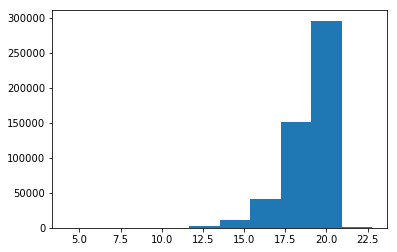

In [5]:
plt.hist(Gmag)

In [8]:
#compare stelllar densities in different regions
stars1 = 0
stars2 = 0

for i in range(len(RA)):
    if ( RA[i] > 249 and RA[i] < 249.5 and DE[i] > -23 and DE[i] < -22.5):
        stars1 = stars1 + 1
    if (RA[i] > 246.5 and RA[i] < 247 and DE[i] > -24.75 and DE[i] < -24.25):
        stars2 = stars2 + 1
density1 = stars1/(0.5*0.5)
density2 = stars2/(0.5*0.5)

print(density1)
print(density2)        

31000.0
392.0


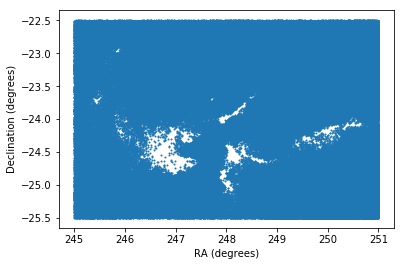

In [6]:
plt.scatter(RA,DE, s = 1)
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

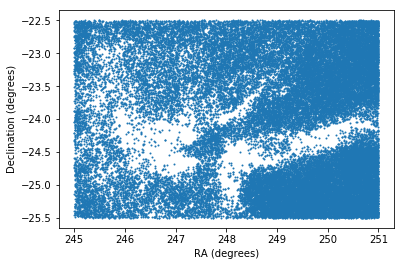

In [11]:
plt.scatter(GRA,GDE, s = 1)
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

In [6]:
#ranges of coordinates and density of stars
RAmin = min(RA)
RAmax = max(RA)
DEmin = min(DE)
DEmax = max(DE)
RA_range = RAmax - RAmin
DE_range = DEmax - DEmin
area = RA_range*DE_range
num = len(RA)
density = num/area
print(RA_range)
print(DE_range)
print(area)
print(num)
print(density)

5.9999703714
2.9999811586
17.9997980664
503325
27962.8137018


In [7]:
#create mapping function

def distance_map(data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour):
    #Function uses KDTree to create a distance map and returns pixel counts along both axes, as well as the
    #scale of degrees to pixel for each axis
    
    #Variables Read In
    #data: an array with two columns of coordinates of stars (RA,DEC)
    #pixel_count: number of pixels for large side of image
    #RAmin, RAmax, DEmin, DEmax: min/max coordinates of image
    #neighbor: number of nearest neighbor to calculate
    #scatter: True/False create a scatter plot of the stars
    #contour: True/False create a contour plot of the distance map
    
    #Varables Returned
    #dist2: distance map
    #pixel_count: pixel count along x axis
    #pixel_count2: pixel count along y axis
    #dRA: degrees to pixel scale along x axis (for RA)
    #dDE: degrees to pixel scale along y axis (for Dec)

    from scipy.spatial import KDTree

    #use KD tree to find distances to nearest neighbor stars
    tree = KDTree(data)
    
    #find distances between min/max RA and DE
    diffRA = (RAmax - RAmin)
    diffDE = (DEmax - DEmin)
    
    #make pixel count along x and y axes equal initially
    pixel_count2 = pixel_count
    
    #makes sure that both x and y axes have same scale of degrees to pixel
    if (diffRA < diffDE):
        dDE = diffDE/pixel_count2
        pixel_count = int(diffRA/dDE)
        dRA = diffRA/pixel_count
    if (diffRA > diffDE):
        dRA = diffRA/pixel_count
        pixel_count2 = int(diffDE/dRA)
        dDE = diffDE/pixel_count2
    if (diffRA == diffDE):
        dRA = diffRA/pixel_count
        dDE = diffDE/pixel_count
        
    #create array of coordinates for image background
    for i in range(0,pixel_count):
        for j in range(0,pixel_count2):
            if (i==0 and j == 0):
                array4 = np.array([RAmin,DEmin])
            else:
                array3 = [RAmin+i*dRA,DEmin+j*dDE]
                array4 = np.vstack((array4,array3))

    #find nearest neighbor distances to background points
    image = tree.query(array4,k=neighbor+1)

    #change array of background points so it is pixel_count x pixel_count2
    dist2 = image[0][:,neighbor-1]
    dist2 = np.resize(dist2,(pixel_count,pixel_count2))
    dist2 = np.rot90(dist2, k=1, axes=(1,0))
    dist2 = np.fliplr(dist2)

    #display map   
    plt.imshow(dist2, origin='lower',extent=[RAmin,RAmax,DEmin,DEmax])
    plt.gca().invert_xaxis()
    plt.show()
    
    #contour plot
    if (contour == True):
        ct = plt.contourf(dist2, cmap='tab10',extent=[RAmin,RAmax,DEmin,DEmax])
        plt.gca().invert_xaxis()
        plt.colorbar()
        plt.show()
    #scatter plot
    if (scatter == True):
        plt.scatter(data[:,0],data[:,1],s = 1,c = 'k')
        plt.gca().invert_xaxis()
        plt.show()
        
    return dist2, pixel_count, pixel_count2, dRA, dDE

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
from scipy.spatial import distance
from scipy import spatial
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from matplotlib.patches import Circle, Wedge, Polygon

In [12]:
def StarSelection(RA,DEC,Source,distArray,L,Gmag,Gvalue=999,specRA=999,specDEC=999):
    
    # ***9 Parameters***
    
    # *1st Parameter* "RA"       :  Array of data containing the RA values for the stars in the region
    # *2nd Parameter* "DEC"      :  Array of data containing the DEC values for the stars in the region
    # *3rd Parameter* "Source"   :  Array of data containing the GAIA ID for each star within the region
    # *4th Parameter* "distArray":  Distance Array created by the distance_map function
    # *5th Parameter* "L"        :  Input the contour level you wish to analyze.
    # *6th Parameter* "Gmag"     :  Array of G Magnitude Values
    # *7th Parameter* "Gvalue    :  Reduces data to all stars with this Gmag value or lower. **Must be decimal/float**
    # *8th Parameter* "specRA"   :  Specific RA location (Optional)
    # *9th Parameter* "specDEC"  :  Specific DEC location (Optional)
    
    # You can get the contour level by looking at the colorbar next to contour plot
    
    # specRA and specDEC are optional parameters. If no RA and DEC are chosen, you will find
    # all stars within the L contour level. If an RA and DEC are chosen, function will
    # grab stars located in a single contour at the L level
    
    # Reduces Star Data based off of user inputted G Mag value
    # Define data array
    data = np.array([RA,DEC])
    if(Gvalue != 999):
        redData = []            
        for i in range(len(Gmag)):
            if(Gmag[i] <= Gvalue):
                redData.append([RA[i],DEC[i],Source[i]])
        redData = np.array(redData) # Will use redData as the stars to be selected within contours
    else:
        max_Gvalue = np.max(Gmag)
        redData = []            
        for i in range(len(Gmag)):
            if(Gmag[i] <= max_Gvalue):
                redData.append([RA[i],DEC[i],Source[i]])
        redData = np.array(redData) # Will use redData as the stars to be selected within contours
    
    Ysize, Xsize = np.shape(distArray) # Calculates X and Y size of distance_map Matrix
    
    
    xgrid = np.linspace(np.min(RA),np.max(RA),Xsize) # Creates grid length in X dir
    ygrid = np.linspace(np.min(DEC),np.max(DEC),Ysize) # Creates grid length in Y dir
    X, Y = np.meshgrid(xgrid,ygrid) # Defines Grid
    X = np.array(X)
    Y = np.array(Y)
    if(specRA != 999 and specDEC != 999):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(14,6)
        ax2.set_facecolor('black')
        ax2.invert_xaxis()
        ax2.contour(X,Y,distances[0])
    else:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(7,6)
    ax1.set_facecolor('black')
    cs = ax1.contour(X,Y,distArray,alpha=0.9,lw=0.6)
    fig.colorbar(cs, ax=ax1)
    ax1.set_xlim([np.min(X),np.max(X)])
    ax1.set_ylim([np.min(Y),np.max(Y)])
    ax1.invert_xaxis()
    
    firstContour = []
    higherContour = []
    insideStars = []
    starCount = 0
    ## The following code will run if user inputs a specifc RA and DEC
    if(specRA != 999 and specDEC != 999):
        G_alpha = 0.6
        size = 5.0
        inside = []
        finalPoly = []
        # get_paths finds every array that contains the (X,Y) points which define each contour at Level L
        for i in range(len(cs.collections[L].get_paths())): # Iterate over each specific array
            p = cs.collections[L].get_paths()[i] # p defines one of these arrays
            v = p.vertices # v contains all (X,Y) points
            x = v[:,0]
            y = v[:,1]
            # If the current array in the loop contains the specific RA and DEC coordinate that the user 
            # inputs, this code will initiate.
            if(specRA >= np.min(x) and specRA <= np.max(x) and specDEC >= np.min(y) and specDEC <= np.max(y)):
                
                ax1.axvline(x=specRA,linestyle='--',color='y',alpha=0.4) # If RA/DEC are inputted, this will plot
                ax1.axhline(y=specDEC,linestyle='--',color='y',alpha=0.4) # a "target" at the coordinate
                ax1.plot(x,y,c='w')
                ax2.plot(x,y,c='w')
                ax2.set_xlim([np.min(x),np.max(x)])
                ax2.set_ylim([np.min(y),np.max(y)])
                ax2.invert_xaxis()
                polygon = v # Creates a Polygon Region from all (X,Y) points in current array
                path = mpltPath.Path(polygon,closed=True) # Creates a path defined by polygon
                inside = path.contains_points(np.transpose([redData[:,0],redData[:,1]])) # *EDITED CODE* Selects all stars located inside path region
                # Inside Array will be a boolean array (True,False). Any star located inside path will
                # have a value of "True"
                finalPoly = [x,y] # Defines the Polygon that contained user inputed RA/DEC
                
                for s in range(len(inside)):
                    if(inside[s] == True): # Find all stars with an associated "True value"
                        firstContour.append(redData[s]) 
    
        # Next, function needs to recognize any higher level contour contained within itself
        finalPoly = np.transpose(np.array(finalPoly)) # Sets proper dimensions
        inside_higher = [] # Will represent stars within a higher level contour 
        for j in range(len(cs.collections[L+1].get_paths())): # All arrays located at L+1 level
            p = cs.collections[L+1].get_paths()[j]
            v = p.vertices
            x = v[:,0]
            y = v[:,1]
            # If current array in loop is inside of the L contour, this code will initiate
            
            if(len(firstContour) > 0 and np.min(x)>=np.min(finalPoly[:,0]) and np.max(x)<=np.max(finalPoly[:,0]) and np.min(y)>=np.min(finalPoly[:,1]) and np.max(y)<=np.max(finalPoly[:,1])):
                polygon = v
                path2 = mpltPath.Path(polygon,closed=True) # defines path of higher level contour
                inside_higher = path2.contains_points(np.transpose([redData[:,0],redData[:,1]])) #EDITED CODE finds all stars inside higher contour
                for s in range(len(inside_higher)):
                    if(inside_higher[s] == True): # find all stars with an associated "True" vale
                        higherContour.append(redData[s])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour) # Defines two arrays that have the same length as the 
        # data.  
        
        # The for loop will find all stars that are within the lower contour "firstContour" and outside
        # of the higher contour "higherContour". All stars that match these conditions will be added to
        # insideStars. 
        for s in range(len(firstContour)):
            if(len(higherContour > 0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                #if(firstContour[s,2] not in higherContour[:,2]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])

        insideStars = np.array(insideStars)
        
    ## WITH NO SPECIFIC REGION ON CONTOUR PLOT
    else:
        G_alpha = 0.3
        size = 0.8
        firstContour = []
        higherContour = []
        inside = []
        for j in range(len(cs.collections[L].get_paths())):
                p = cs.collections[L].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                polygon = v
                path = mpltPath.Path(polygon,closed=True)
                inside = path.contains_points(np.transpose([redData[:,0],redData[:,1]]))
                for i in range(len(inside)):
                    if(inside[i] == True):
                        #starCount = starCount + 1
                        firstContour.append(redData[i])
                if(len(firstContour) > 0): 
                    ax1.plot(x,y,c='w',alpha=1.0,lw=0.7)
        
        for j in range(len(cs.collections[L+1].get_paths())):
            p = cs.collections[L+1].get_paths()[j]
            v = p.vertices
            polygon = v 
            path = mpltPath.Path(polygon,closed=True)
            inside_higher = path.contains_points(np.transpose([redData[:,0],redData[:,1]]))
            for i in range(len(inside_higher)):
                    if(inside_higher[i] == True):
                        starCount = starCount + 1
                        higherContour.append(redData[i])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour)
        for s in range(len(firstContour)):
            if(len(higherContour >0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])
        insideStars = np.array(insideStars)
    
    if(Gvalue != 999):
        print('Gmag <= ',Gvalue,'\nTotal Stars: ',len(redData))
    else:
        print('No cut-off Gmag value \nTotal Stars: ',len(redData))
    
    ax1.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',alpha=G_alpha,marker='*')
    if(specRA != 999 and specDEC != 999):
        ax2.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',marker='*')
    if(len(insideStars) > 0):
        ax1.scatter(insideStars[:,0],insideStars[:,1],s=1.0,c='r',marker='*')
        if(specRA != 999 and specDEC != 999):
            ax2.scatter(insideStars[:,0],insideStars[:,1],s=15.0,c='r',marker='*')
            ax1.set_title('Plot of Stars Located in Specific Contour')
            ax2.set_title('Magnified Image of Chosen Contour')
            ax2.set_xlabel('RA')
            ax2.set_ylabel('DEC')
            
        else:
            ax1.set_title('Plot of Stars Located in Chosen Contour Level')
        ax1.set_xlabel('RA')
        ax1.set_ylabel('DEC')
        plt.show()
        print('Total Stars within contour: ',len(insideStars),'\n\n')
        print('Star ID              RA                    DEC\n')
        for i in range(len(insideStars)):
            print(insideStars[i,2],'           ',insideStars[i,0],'            ',insideStars[i,1])
    else:
        print('No Stars Found')
        plt.show()

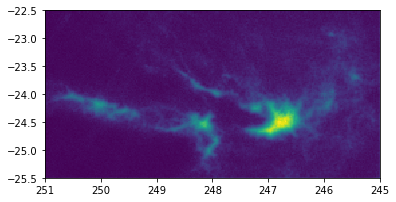

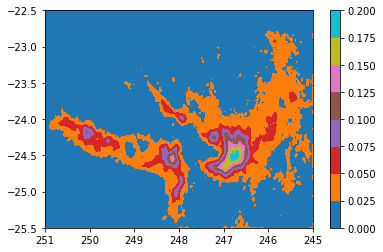

Elapsed time is: 24.12749593704939


In [10]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 250
image = False
scatter = False
contour = True
neighbor = 20

distances = distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))


No cut-off Gmag value 
Total Stars:  503325


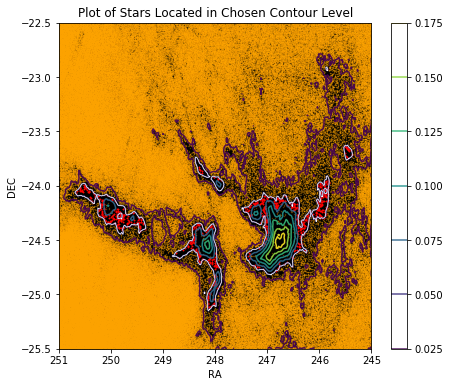

Total Stars within contour:  890 


Star ID              RA                    DEC

32767.0             248.141818135              -25.1157408141
32767.0             248.123168217              -25.113092675
32767.0             248.107595447              -25.117266985
32767.0             248.098216306              -25.1154295327
32767.0             248.072430858              -25.1077511134
32767.0             248.110821247              -25.1133929409
32767.0             248.14004722              -25.086082077
32767.0             248.137017578              -25.076515039
32767.0             248.149273725              -25.0536451727
32767.0             248.146183681              -25.0521361591
32767.0             248.139988699              -25.033743052
32767.0             248.136474638              -25.0345853122
32767.0             248.140299307              -25.0262575618
32767.0             248.159271077              -25.0290958353
32767.0             248.145252806              -25.019

32767.0             246.420019384              -24.4381142001
32767.0             246.351304549              -24.4658211535
32767.0             246.330102881              -24.4480877982
32767.0             246.300186445              -24.4420421597
32767.0             246.30166738              -24.4308738935
32767.0             246.356541474              -24.4303563615
32767.0             246.355936418              -24.427032204
32767.0             246.31634201              -24.4196939724
32767.0             246.362013999              -24.405315924
32767.0             246.359185454              -24.3991905565
32767.0             246.361380466              -24.3935012379
32767.0             246.363538296              -24.3892877376
32767.0             246.401112945              -24.4133247879
32767.0             246.413257338              -24.3925756356
32767.0             246.408841929              -24.3768273089
32767.0             246.422032043              -24.3602989495
32767.0     

32767.0             249.775090931              -24.383958794
32767.0             249.778938648              -24.3770811988
32767.0             249.777607671              -24.3763952309
32767.0             249.814940833              -24.3250435996
32767.0             249.811191876              -24.3232282996
32767.0             249.773245829              -24.3378797231
32767.0             249.785945176              -24.2992660969
32767.0             249.877462949              -24.3599902726
32767.0             249.861625194              -24.3482137672
32767.0             249.875182387              -24.3305965054
32767.0             249.865685955              -24.3285893096
32767.0             249.864525508              -24.3098453567
32767.0             249.911068035              -24.3066111624
32767.0             249.945534898              -24.3060494343
32767.0             249.933836536              -24.3043379071
32767.0             249.957688259              -24.2935129154
32767.0  

32767.0             245.946080325              -24.1683804818
32767.0             246.116635423              -24.2560593802
32767.0             246.065919586              -24.2703134037
32767.0             246.069616955              -24.2493569032
32767.0             246.069727566              -24.2380807803
32767.0             246.045656594              -24.2516138368
32767.0             246.052219376              -24.227220174
32767.0             246.05208806              -24.2184767624
32767.0             246.028437299              -24.2262285652
32767.0             246.032305116              -24.2189606194
32767.0             246.014619482              -24.2211302483
32767.0             246.010627417              -24.2140764266
32767.0             246.021964216              -24.2011341745
32767.0             246.0047116              -24.1918728609
32767.0             246.011932677              -24.1714258228
32767.0             245.994334157              -24.1838102468
32767.0     

In [15]:
StarSelection(X1,Y1,Source,distances[0],1,Gmag)

No cut-off Gmag value 
Total Stars:  503325


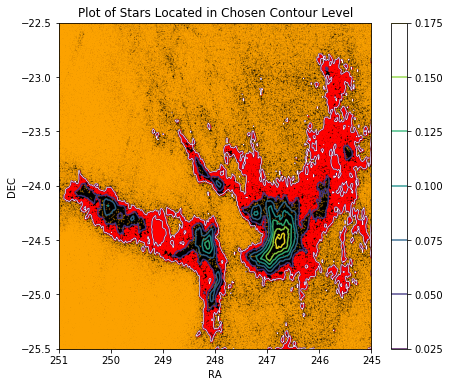

Total Stars within contour:  20021 


Star ID              RA                    DEC

32767.0             245.043552948              -25.4953136508
32767.0             245.033633471              -25.4971521264
32767.0             245.035581746              -25.4968942313
32767.0             245.058208798              -25.4986550922
32767.0             246.128831557              -25.4942103712
32767.0             246.363667852              -25.4956024782
32767.0             246.376584387              -25.4966665888
32767.0             246.66445254              -25.4967005208
32767.0             246.574443011              -25.4979139787
32767.0             246.578378262              -25.4948812697
32767.0             246.5764966              -25.4924620718
32767.0             246.629111916              -25.4975283197
32767.0             246.634994238              -25.4980343239
32767.0             246.656435712              -25.4938695313
32767.0             246.647690508              -2

32767.0             245.011635106              -24.4034678273
32767.0             245.010643716              -24.3942468068
32767.0             245.004984592              -24.3855356308
32767.0             245.007866097              -24.383186257
32767.0             245.00675278              -23.7980578945
32767.0             245.013166488              -23.7980217724
32767.0             245.005932454              -23.7919664707
32767.0             245.008374657              -23.7858476473
32767.0             245.001593023              -23.7894738182
32767.0             245.00538183              -23.7825690596
32767.0             245.005212468              -23.7680807463
32767.0             245.011824354              -23.7631251853
32767.0             245.003244883              -23.7618683924
32767.0             245.013871967              -23.7550773805
32767.0             245.015625107              -23.7533276314
32767.0             245.00308266              -23.7528902004
32767.0     

32767.0             248.103954655              -25.2151162148
32767.0             248.122986279              -25.2081831742
32767.0             248.10716771              -25.2098112815
32767.0             247.959521361              -25.32727719
32767.0             247.979459045              -25.3268049003
32767.0             247.967581317              -25.3210557555
32767.0             247.943272829              -25.323543542
32767.0             247.945793077              -25.3229971119
32767.0             247.960793824              -25.3232333132
32767.0             247.92079858              -25.3289933433
32767.0             247.91362697              -25.3282871593
32767.0             247.923465798              -25.3286013485
32767.0             247.927266039              -25.3210361098
32767.0             247.901305453              -25.3229894545
32767.0             247.932605848              -25.3151055876
32767.0             247.932667403              -25.3148559253
32767.0       

32767.0             248.219235877              -25.2746723152
32767.0             248.21828164              -25.2733379419
32767.0             248.958577795              -24.6819576801
32767.0             248.936574015              -24.6820705507
32767.0             248.953323688              -24.6805238195
32767.0             248.948614206              -24.6762749557
32767.0             248.944162818              -24.6739002613
32767.0             248.863530303              -24.688784138
32767.0             248.878968337              -24.6820198369
32767.0             248.864918683              -24.6863038947
32767.0             248.845850154              -24.6885333054
32767.0             248.850364512              -24.6865512959
32767.0             248.865135843              -24.674212098
32767.0             248.862410473              -24.6659635213
32767.0             248.893498398              -24.6794375252
32767.0             248.942098848              -24.6679775045
32767.0    

32767.0             248.993380082              -24.6536303471
32767.0             248.993509691              -24.6494914428
32767.0             248.984075653              -24.6516129213
32767.0             248.97875973              -24.6395748135
32767.0             249.037005753              -24.6528056279
32767.0             249.048200121              -24.651611357
32767.0             249.047168223              -24.6471050921
32767.0             249.048552366              -24.6349872449
32767.0             249.032160363              -24.6351370202
32767.0             249.03595152              -24.6332192978
32767.0             249.053960452              -24.6350470856
32767.0             249.05825737              -24.6294989786
32767.0             249.064405438              -24.627242532
32767.0             249.065009662              -24.6221181942
32767.0             249.045190468              -24.6294705013
32767.0             249.047885487              -24.6183788765
32767.0      

32767.0             249.26993242              -24.4714964763
32767.0             249.293643063              -24.4653700414
32767.0             249.291420585              -24.4651525001
32767.0             249.269479928              -24.4620033553
32767.0             249.28034031              -24.4418392346
32767.0             249.304450094              -24.4559426012
32767.0             249.317945346              -24.4395440561
32767.0             249.283936807              -24.4422216163
32767.0             249.346336706              -24.4590929028
32767.0             249.345890238              -24.4504135359
32767.0             249.329528              -24.4381252175
32767.0             249.335234303              -24.4291726922
32767.0             249.371235409              -24.4202769884
32767.0             249.379335527              -24.4160589953
32767.0             249.357293199              -24.4139511179
32767.0             249.32956969              -24.4094608582
32767.0       

32767.0             249.183592621              -24.385917623
32767.0             249.176786972              -24.3751410488
32767.0             249.176767361              -24.3737954376
32767.0             249.194679508              -24.360526174
32767.0             249.212816614              -24.3694337151
32767.0             249.219218146              -24.3727801036
32767.0             249.21816381              -24.3601088315
32767.0             249.209185582              -24.3589661478
32767.0             249.214557747              -24.3479038367
32767.0             249.213152904              -24.3417448088
32767.0             249.269244759              -24.3596617011
32767.0             249.269095352              -24.3532514909
32767.0             249.255473659              -24.3575105452
32767.0             249.254805361              -24.3558675151
32767.0             249.249365504              -24.3547888398
32767.0             249.261380502              -24.3521680767
32767.0    

32767.0             249.464389428              -24.2220445065
32767.0             249.461141539              -24.2175929906
32767.0             249.475938837              -24.2113881627
32767.0             249.390122375              -24.237159617
32767.0             249.408286884              -24.2342934188
32767.0             249.409367899              -24.2340422501
32767.0             249.408212836              -24.2305663777
32767.0             249.40991451              -24.2220867596
32767.0             249.649736392              -24.2522295542
32767.0             249.641369156              -24.2484319786
32767.0             249.593093782              -24.2442713825
32767.0             249.600875574              -24.2460504959
32767.0             249.60830819              -24.240074912
32767.0             249.613823644              -24.2316163029
32767.0             249.593475246              -24.236582773
32767.0             249.597111546              -24.23110403
32767.0        

32767.0             248.280000287              -24.9615377344
32767.0             248.275700474              -24.9577800398
32767.0             248.27683107              -24.9563564108
32767.0             248.286923668              -24.9554303258
32767.0             248.271570699              -24.9480913035
32767.0             248.227294489              -24.9516396106
32767.0             248.216223539              -24.9590568696
32767.0             248.230658094              -24.9391869279
32767.0             248.250418832              -24.937191351
32767.0             248.231668252              -24.9273270772
32767.0             248.238076406              -24.9247015622
32767.0             248.242391843              -24.9238391174
32767.0             248.291799453              -24.9520898731
32767.0             248.29219991              -24.9425127161
32767.0             248.279393079              -24.9401706349
32767.0             248.291784253              -24.9275602124
32767.0    

32767.0             248.24996534              -24.7650419149
32767.0             248.291402694              -24.7806568057
32767.0             248.299165889              -24.7763748166
32767.0             248.291778571              -24.776050585
32767.0             248.30542304              -24.7679281698
32767.0             248.301143799              -24.7614848586
32767.0             248.309496717              -24.7552178877
32767.0             248.327195782              -24.749676364
32767.0             248.271649907              -24.7477358215
32767.0             248.276013844              -24.7408925342
32767.0             248.123075961              -24.8551142895
32767.0             248.127845498              -24.8502641099
32767.0             248.127423219              -24.8442293716
32767.0             248.119204542              -24.8398259214
32767.0             248.110806979              -24.8432831401
32767.0             248.134287184              -24.8437908608
32767.0     

32767.0             248.673259314              -24.7125638314
32767.0             248.675628028              -24.7065832391
32767.0             248.658681723              -24.6983611429
32767.0             248.661631087              -24.696287563
32767.0             248.675914347              -24.6893289199
32767.0             248.727081753              -24.7019973612
32767.0             248.728996724              -24.6994990964
32767.0             248.729786924              -24.6880236294
32767.0             248.745022182              -24.6914320236
32767.0             248.749422819              -24.6877658171
32767.0             248.744249988              -24.6764910675
32767.0             248.734390855              -24.6666229441
32767.0             248.735102384              -24.6613503451
32767.0             248.694042165              -24.6693271176
32767.0             248.831229366              -24.6792056889
32767.0             248.857325108              -24.6641159509
32767.0  

32767.0             248.50504391              -24.6524108137
32767.0             248.513248391              -24.6439301539
32767.0             248.503529516              -24.637914249
32767.0             248.507197626              -24.6336896714
32767.0             248.49183377              -24.6325024845
32767.0             248.487412511              -24.6286715085
32767.0             248.434908943              -24.6531175378
32767.0             248.426179134              -24.6328213894
32767.0             248.41730196              -24.6380066422
32767.0             248.414114344              -24.6332093296
32767.0             248.442411741              -24.6380302277
32767.0             248.461404751              -24.6241360224
32767.0             248.447838748              -24.6264515402
32767.0             248.437745137              -24.6119229251
32767.0             248.403015918              -24.6364301805
32767.0             248.404692628              -24.6005093719
32767.0     

32767.0             248.455788941              -24.4204432804
32767.0             248.449499474              -24.4235504014
32767.0             248.453269788              -24.4155581953
32767.0             248.45156581              -24.4085713428
32767.0             248.475476051              -24.4082235054
32767.0             248.456271356              -24.4068210308
32767.0             248.553235559              -24.4560379578
32767.0             248.557768097              -24.4466608131
32767.0             248.565001119              -24.4414258073
32767.0             248.574286339              -24.4417866602
32767.0             248.559579319              -24.4408619459
32767.0             248.567310261              -24.4360003213
32767.0             248.551011659              -24.4387843799
32767.0             248.558147077              -24.4271674072
32767.0             248.557702644              -24.4224206571
32767.0             248.553949556              -24.4212790988
32767.0  

32767.0             247.828038721              -24.7033291208
32767.0             247.828532846              -24.7023014945
32767.0             247.831243505              -24.7015646582
32767.0             247.826398613              -24.699965466
32767.0             247.82706459              -24.6968339996
32767.0             247.796413721              -24.7013828174
32767.0             247.795031596              -24.6997565588
32767.0             247.784941943              -24.6974168683
32767.0             247.783397951              -24.6960911045
32767.0             247.819788165              -24.6872555884
32767.0             247.871034003              -24.6852762918
32767.0             247.845988428              -24.6888800905
32767.0             247.842877024              -24.685481465
32767.0             247.837906438              -24.6845457956
32767.0             247.831613836              -24.6855215605
32767.0             247.838694018              -24.6790617187
32767.0    

32767.0             248.440036181              -24.3120210616
32767.0             248.437678862              -24.3089427165
32767.0             248.436687332              -24.3073521139
32767.0             248.428012714              -24.3007332903
32767.0             248.410733467              -24.3038339934
32767.0             248.396477524              -24.296033167
32767.0             248.389554372              -24.2948731224
32767.0             248.39248151              -24.29314207
32767.0             248.391161419              -24.2889673899
32767.0             248.406497295              -24.2901640304
32767.0             248.403996751              -24.2796163123
32767.0             248.27297832              -24.3238542749
32767.0             248.286722274              -24.3229652092
32767.0             248.298432271              -24.3174571238
32767.0             248.294393074              -24.317840035
32767.0             248.297859713              -24.3148499846
32767.0       

32767.0             249.045503095              -24.4770112905
32767.0             249.025972706              -24.4779703727
32767.0             249.024726656              -24.4782129052
32767.0             249.025536518              -24.4724981043
32767.0             249.06362435              -24.4752803743
32767.0             249.05562878              -24.4747348807
32767.0             249.073285087              -24.4628738654
32767.0             249.076230586              -24.464139493
32767.0             249.074894873              -24.4607556439
32767.0             249.069872498              -24.454393185
32767.0             249.052442322              -24.4658021341
32767.0             249.054073656              -24.4606662029
32767.0             249.045701368              -24.4608908098
32767.0             249.052237319              -24.4558939184
32767.0             249.05491326              -24.4539059605
32767.0             249.054861604              -24.4519055325
32767.0      

32767.0             249.061080164              -24.4321043372
32767.0             249.067143305              -24.4261241711
32767.0             249.050085419              -24.4295587419
32767.0             249.052774993              -24.4265163176
32767.0             249.061324622              -24.4279579192
32767.0             249.062858212              -24.4250990607
32767.0             249.074559622              -24.4239298005
32767.0             249.071681288              -24.4233585347
32767.0             249.075121517              -24.4222039017
32767.0             249.060863687              -24.4189856513
32767.0             249.066035331              -24.4169739569
32767.0             249.070408855              -24.4153871794
32767.0             249.044167583              -24.4205490671
32767.0             249.051324039              -24.4151533548
32767.0             249.065525106              -24.4085315538
32767.0             249.056595965              -24.410214984
32767.0  

32767.0             249.150864343              -24.2785798279
32767.0             249.150456083              -24.2741309522
32767.0             249.178441212              -24.266082583
32767.0             249.189554046              -24.2637068722
32767.0             249.19826835              -24.2610324405
32767.0             249.180328101              -24.2544251298
32767.0             249.177194877              -24.2501105895
32767.0             249.181999832              -24.2482194549
32767.0             249.189680562              -24.2525519418
32767.0             249.151156167              -24.2684564314
32767.0             249.147141557              -24.2563182235
32767.0             249.156397304              -24.263008009
32767.0             249.164787953              -24.252358107
32767.0             249.158397338              -24.2509703706
32767.0             249.141342209              -24.2571198674
32767.0             249.152060784              -24.246904493
32767.0      

32767.0             249.244746052              -24.2428555408
32767.0             249.301811848              -24.2542363845
32767.0             249.223297518              -24.2456708921
32767.0             249.202445789              -24.2437057886
32767.0             249.204618869              -24.2400961669
32767.0             250.283784974              -24.3561548827
32767.0             250.277865431              -24.3579487635
32767.0             250.28156012              -24.3519733183
32767.0             250.269595318              -24.3548325086
32767.0             250.275792606              -24.3459595974
32767.0             250.302196982              -24.3653491708
32767.0             250.296693493              -24.3560887195
32767.0             250.328029576              -24.3475983619
32767.0             250.334762602              -24.3381049019
32767.0             250.337273953              -24.3392779764
32767.0             250.345312139              -24.3290361248
32767.0  

32767.0             250.319906992              -24.1851172765
32767.0             250.308613014              -24.1861689294
32767.0             250.297552563              -24.1698008156
32767.0             250.403441488              -24.2091354174
32767.0             250.408567646              -24.2025949842
32767.0             250.404657867              -24.2027687117
32767.0             250.410804965              -24.195508752
32767.0             250.416969015              -24.1953005109
32767.0             250.393393646              -24.1994021721
32767.0             250.389591826              -24.1950173644
32767.0             250.382465066              -24.1969478172
32767.0             250.402727546              -24.1906870449
32767.0             250.438400712              -24.1768961403
32767.0             250.436113145              -24.1754164507
32767.0             250.436492176              -24.1664668873
32767.0             250.413126555              -24.1721196624
32767.0  

32767.0             250.850023704              -24.0558226294
32767.0             250.849750538              -24.0473416926
32767.0             250.862151992              -24.0401275121
32767.0             250.860321583              -24.0375846468
32767.0             250.864253385              -24.038001806
32767.0             250.858774235              -24.0368490331
32767.0             250.793681779              -24.0810600515
32767.0             250.811934057              -24.0747815016
32767.0             250.813934856              -24.0743882487
32767.0             250.813060955              -24.0724022166
32767.0             250.816773826              -24.0716690021
32767.0             250.808849663              -24.0716060943
32767.0             250.798842757              -24.0736571148
32767.0             250.788780544              -24.0759458439
32767.0             250.823894425              -24.0615714283
32767.0             250.771802072              -24.0650502848
32767.0  

32767.0             249.914479542              -24.1147999918
32767.0             249.901860592              -24.1108657603
32767.0             249.91137532              -24.0973032832
32767.0             249.830842052              -24.1683197034
32767.0             249.827173372              -24.1674596088
32767.0             249.836176985              -24.1618656423
32767.0             249.842360164              -24.151779384
32767.0             249.834264233              -24.1534882175
32767.0             249.84238549              -24.1473498104
32767.0             249.824553156              -24.1528377515
32767.0             249.813147592              -24.1566312354
32767.0             249.812372951              -24.1580010251
32767.0             249.816500722              -24.1496172202
32767.0             249.83360243              -24.1455185246
32767.0             249.832503138              -24.1415458036
32767.0             249.823765064              -24.1413022643
32767.0     

32767.0             248.240655977              -23.9512627827
32767.0             248.236874398              -23.9466379036
32767.0             248.252346453              -23.9350863577
32767.0             248.299437953              -23.9587196075
32767.0             248.285304538              -23.9625606127
32767.0             248.307970644              -23.9527548955
32767.0             248.280359696              -23.9580255472
32767.0             248.28521798              -23.9500712427
32767.0             248.273870679              -23.9499493394
32767.0             248.316087672              -23.9411078814
32767.0             248.322596642              -23.9309581487
32767.0             248.32646255              -23.9301924639
32767.0             248.324849201              -23.9223116745
32767.0             248.253044109              -23.9341815334
32767.0             248.261878813              -23.9299540313
32767.0             248.280531155              -23.9180346386
32767.0   

32767.0             246.148006671              -24.823681659
32767.0             246.146440916              -24.8218469646
32767.0             246.152998078              -24.8226933939
32767.0             246.158416329              -24.8110146976
32767.0             246.187281916              -24.8199193132
32767.0             246.170438549              -24.8109779102
32767.0             246.182929012              -24.7984733106
32767.0             246.181688221              -24.7894199821
32767.0             246.225658914              -24.818433206
32767.0             246.224746997              -24.8136953802
32767.0             246.213293083              -24.8106791752
32767.0             246.225069994              -24.8086123045
32767.0             246.226178684              -24.7902413289
32767.0             246.24103704              -24.7966303213
32767.0             246.252921528              -24.7863013176
32767.0             246.227712664              -24.7901387422
32767.0    

32767.0             247.1235004              -24.8284922354
32767.0             247.114366131              -24.8296507513
32767.0             247.132021792              -24.8192856322
32767.0             247.1497745              -24.8124796412
32767.0             247.146981462              -24.8116501027
32767.0             247.142423258              -24.8056006543
32767.0             247.138660406              -24.8066974118
32767.0             247.150131513              -24.7931985977
32767.0             247.215948507              -24.8370952649
32767.0             247.214831196              -24.8335492398
32767.0             247.219587294              -24.827577727
32767.0             247.218041273              -24.8264518738
32767.0             247.210091325              -24.8284981696
32767.0             247.21737386              -24.8245315201
32767.0             247.214845833              -24.819419434
32767.0             247.215615746              -24.8142171364
32767.0        

32767.0             247.224611124              -24.5501017399
32767.0             247.232036832              -24.5462358587
32767.0             247.219806372              -24.5464717348
32767.0             247.174689515              -24.5581531955
32767.0             247.173118908              -24.5566663378
32767.0             247.174920274              -24.5539022825
32767.0             247.191181139              -24.5411963183
32767.0             247.18759682              -24.5407508481
32767.0             247.18062882              -24.5399656964
32767.0             247.151371226              -24.5396353672
32767.0             247.159014067              -24.5363928608
32767.0             247.169997653              -24.5367473363
32767.0             247.172035073              -24.5353302297
32767.0             247.17916438              -24.5339294634
32767.0             247.171408716              -24.5288788175
32767.0             247.184804569              -24.533132789
32767.0     

32767.0             246.558901465              -24.7533077775
32767.0             246.561397263              -24.7527207444
32767.0             246.569907793              -24.7458966701
32767.0             246.544532867              -24.7513048352
32767.0             246.499653959              -24.7434405307
32767.0             246.361821676              -24.8643291977
32767.0             246.370192991              -24.8508683438
32767.0             246.345429747              -24.8573232839
32767.0             246.338916077              -24.8507809771
32767.0             246.35510757              -24.8448186683
32767.0             246.365410739              -24.8383520811
32767.0             246.374033133              -24.844454188
32767.0             246.389400309              -24.8340441864
32767.0             246.370237408              -24.8332147189
32767.0             246.362425057              -24.8272013841
32767.0             246.368817344              -24.8289202554
32767.0   

32767.0             246.602919827              -24.764021098
32767.0             246.596341231              -24.7630158579
32767.0             246.597716431              -24.757123997
32767.0             246.591673167              -24.7471480915
32767.0             246.584512949              -24.7469594801
32767.0             246.591241973              -24.7444704105
32767.0             246.601578521              -24.7334041191
32767.0             246.623199288              -24.7382740415
32767.0             246.623070867              -24.735863282
32767.0             246.629903158              -24.7317196443
32767.0             246.629767716              -24.7246231128
32767.0             246.616129674              -24.7308527957
32767.0             246.654956443              -24.7366398777
32767.0             246.667767714              -24.7301118711
32767.0             246.598672363              -24.7206330886
32767.0             246.591836176              -24.7101214246
32767.0    

32767.0             246.143312274              -24.5854629041
32767.0             246.162773839              -24.5771538912
32767.0             246.164984401              -24.5709656173
32767.0             246.155630756              -24.575830777
32767.0             246.178058485              -24.5764612637
32767.0             246.184604613              -24.5604856777
32767.0             246.181565482              -24.5530185346
32767.0             246.183107408              -24.5476615312
32767.0             246.283118248              -24.574162062
32767.0             246.247029539              -24.5695240979
32767.0             246.270782305              -24.5463679427
32767.0             246.299284875              -24.5532521515
32767.0             246.277356172              -24.543875047
32767.0             246.273811476              -24.5425039902
32767.0             246.280462631              -24.5408753581
32767.0             246.280491276              -24.5408984945
32767.0    

32767.0             245.411816292              -24.2235050448
32767.0             245.410172077              -24.2223538401
32767.0             245.424155262              -24.2158001994
32767.0             245.432066692              -24.2084763899
32767.0             245.436919174              -24.2054376494
32767.0             245.433940684              -24.200453492
32767.0             245.442037118              -24.1931018889
32767.0             245.442123152              -24.1907979496
32767.0             245.42588265              -24.2006282616
32767.0             245.427307557              -24.1955042313
32767.0             245.430851565              -24.1813795066
32767.0             245.393876028              -24.2085041947
32767.0             245.393940501              -24.2065218521
32767.0             245.400583931              -24.1907213665
32767.0             245.400597146              -24.1876671409
32767.0             245.399022752              -24.1851739508
32767.0   

32767.0             246.162752119              -24.5015546838
32767.0             246.153011075              -24.4923258311
32767.0             246.180878778              -24.4989175308
32767.0             246.181689207              -24.4915597922
32767.0             246.183470299              -24.4849351845
32767.0             246.180176623              -24.4847382679
32767.0             246.187568435              -24.4856021187
32767.0             246.195422042              -24.4799996664
32767.0             246.170509437              -24.4851046788
32767.0             246.162495059              -24.4822025413
32767.0             246.226144645              -24.4945830701
32767.0             246.228765562              -24.4882485231
32767.0             246.219486581              -24.4881452893
32767.0             246.229658081              -24.4788854912
32767.0             246.212950982              -24.4893360178
32767.0             246.211734563              -24.4791541746
32767.0 

32767.0             245.982341618              -24.3732700438
32767.0             245.937622872              -24.3900917123
32767.0             245.951724491              -24.3837208371
32767.0             245.936817006              -24.3772649551
32767.0             245.941203695              -24.3746081167
32767.0             245.932839336              -24.3674264727
32767.0             245.950719012              -24.3532172759
32767.0             245.950738769              -24.3511053757
32767.0             245.878002566              -24.3996359228
32767.0             245.887321302              -24.3939626889
32767.0             245.883379071              -24.3945080738
32767.0             245.862048752              -24.4069879027
32767.0             245.859422126              -24.402346871
32767.0             245.865449013              -24.392827826
32767.0             245.897668867              -24.3903418712
32767.0             245.889196151              -24.3917853281
32767.0   

32767.0             246.470183535              -24.1185087621
32767.0             246.491238873              -24.1204047494
32767.0             246.501973916              -24.1189923748
32767.0             246.500361059              -24.1078112972
32767.0             246.486092962              -24.1000677409
32767.0             246.540129199              -24.1160693401
32767.0             246.518699871              -24.1157162885
32767.0             246.524008144              -24.1099130674
32767.0             246.532310259              -24.1035284261
32767.0             246.529636635              -24.0977142179
32767.0             246.533899791              -24.0939008964
32767.0             246.560498105              -24.1051711898
32767.0             246.563276702              -24.0999097242
32767.0             246.557102413              -24.1027422526
32767.0             246.569100963              -24.085773465
32767.0             246.539094994              -24.0954052624
32767.0  

32767.0             246.674707816              -24.0039984962
32767.0             246.670757443              -24.005268473
32767.0             246.689954018              -24.0057890192
32767.0             246.710906263              -23.9949500605
32767.0             246.719180539              -23.9860171624
32767.0             246.712186875              -23.9784281124
32767.0             246.701965874              -23.9808453399
32767.0             246.75016466              -24.0067396508
32767.0             246.759419269              -23.9967543703
32767.0             246.76356556              -23.9962783026
32767.0             246.760233049              -23.9934605585
32767.0             246.758511522              -23.9936155352
32767.0             246.746543713              -23.9830820266
32767.0             246.751265359              -23.9803288247
32767.0             246.748954579              -23.976752507
32767.0             246.754789075              -23.972310539
32767.0      

32767.0             246.328630933              -23.9977328321
32767.0             246.35248967              -23.9969145249
32767.0             246.363155275              -23.9923351511
32767.0             246.370489205              -23.9879205544
32767.0             246.344152199              -23.982699245
32767.0             246.408337165              -23.9989307427
32767.0             246.409554954              -23.9983371942
32767.0             246.405172041              -24.0006660139
32767.0             246.396025252              -23.9957061282
32767.0             246.412772998              -23.9987294089
32767.0             246.387518695              -23.9861493529
32767.0             246.404594515              -23.9861701781
32767.0             246.397907135              -23.9738622609
32767.0             246.40305285              -23.9725531316
32767.0             246.425503495              -23.9847399094
32767.0             246.423916186              -23.9792288842
32767.0    

32767.0             246.211103442              -23.8922299865
32767.0             246.1936884              -23.8947947979
32767.0             246.228017327              -23.8828894084
32767.0             246.225462011              -23.8825934553
32767.0             246.232480322              -23.8790847527
32767.0             246.21964565              -23.8816118964
32767.0             246.222238348              -23.8791054067
32767.0             246.239939662              -23.8706244618
32767.0             246.239808037              -23.8699008565
32767.0             246.238937374              -23.8694226233
32767.0             246.207144917              -23.8673662912
32767.0             246.210270606              -23.8656666514
32767.0             246.213594796              -23.8662161845
32767.0             246.213249727              -23.863604015
32767.0             246.218074761              -23.8596802572
32767.0             246.218372048              -23.856050199
32767.0      

32767.0             245.653276276              -24.1139520462
32767.0             245.666295115              -24.1046763915
32767.0             245.658718311              -24.1054382247
32767.0             245.650135214              -24.0985536792
32767.0             245.653275139              -24.0988736648
32767.0             245.67761377              -24.0996132703
32767.0             245.679865398              -24.0973173476
32767.0             245.674795436              -24.094582929
32767.0             245.682311524              -24.0957640521
32767.0             245.687064152              -24.090496106
32767.0             245.684239002              -24.0804613665
32767.0             245.635766543              -24.1045858001
32767.0             245.634877812              -24.1032128215
32767.0             245.633577403              -24.0987090532
32767.0             245.630179274              -24.0994946057
32767.0             245.630458459              -24.0945559423
32767.0    

32767.0             245.874133201              -23.8523049479
32767.0             245.912264913              -23.8797486967
32767.0             245.922113168              -23.863253618
32767.0             245.941126809              -23.8469629863
32767.0             245.950151083              -23.8416932467
32767.0             245.945636905              -23.8417927739
32767.0             245.921738412              -23.8452734685
32767.0             245.936922274              -23.8428649542
32767.0             245.892269895              -23.8480218528
32767.0             245.896993241              -23.8423441257
32767.0             245.898658564              -23.840467631
32767.0             245.892113168              -23.8389526736
32767.0             245.910581304              -23.8345665787
32767.0             245.564884047              -24.1288688807
32767.0             245.571152627              -24.1163354399
32767.0             245.563597044              -24.1104026517
32767.0   

32767.0             245.481150748              -24.0005368131
32767.0             245.492207738              -23.9949618779
32767.0             245.498798047              -23.9888175328
32767.0             245.482437248              -23.9913583225
32767.0             245.487547687              -23.9836045878
32767.0             245.465725431              -23.9983844394
32767.0             245.467019409              -23.9809242824
32767.0             245.482176806              -23.9850635668
32767.0             245.475706768              -23.980024537
32767.0             245.477609786              -23.9716366632
32767.0             245.523812883              -24.0039725674
32767.0             245.531195762              -23.9930900105
32767.0             245.509337897              -23.9958086083
32767.0             245.528890646              -23.9773301708
32767.0             245.521372428              -23.9719539681
32767.0             245.541598875              -23.9857945575
32767.0  

32767.0             245.724411216              -23.8360827562
32767.0             245.711743068              -23.8384414869
32767.0             245.712264061              -23.8369609544
32767.0             245.716581567              -23.834339377
32767.0             245.750417805              -23.834342225
32767.0             245.743332755              -23.8358753151
32767.0             245.748818489              -23.8332502843
32767.0             245.759615871              -23.8283505441
32767.0             245.747930462              -23.8239569913
32767.0             245.737354347              -23.8282987521
32767.0             245.735265958              -23.8222449258
32767.0             245.741134054              -23.8183011889
32767.0             245.741709385              -23.8174704071
32767.0             245.746563118              -23.8190861667
32767.0             245.735318315              -23.819399347
32767.0             245.744459041              -23.8112916445
32767.0    

32767.0             245.717485033              -23.7709505971
32767.0             245.717978302              -23.7695185881
32767.0             245.731184246              -23.7693399613
32767.0             245.733306281              -23.761199383
32767.0             245.730809352              -23.7600901805
32767.0             245.731357094              -23.7593524227
32767.0             245.698729431              -23.7658321279
32767.0             245.719888979              -23.7651745925
32767.0             245.723358444              -23.7610619813
32767.0             245.727929593              -23.7552224741
32767.0             245.726343561              -23.754677126
32767.0             245.711146952              -23.7536411337
32767.0             245.720673068              -23.748925029
32767.0             245.719138777              -23.7471528491
32767.0             245.741119642              -23.7593198353
32767.0             245.749155726              -23.757320711
32767.0     

32767.0             246.08629929              -23.8808814977
32767.0             246.112760798              -23.8674086653
32767.0             246.109468771              -23.8629856522
32767.0             246.084306687              -23.874815088
32767.0             246.083942261              -23.8612614281
32767.0             246.09343236              -23.8498377052
32767.0             246.117825257              -23.8551326351
32767.0             246.13000161              -23.8505993648
32767.0             246.131359397              -23.846001111
32767.0             246.123928208              -23.8428350466
32767.0             246.105453977              -23.844920396
32767.0             246.119179303              -23.8347441394
32767.0             246.109528706              -23.8374585517
32767.0             246.06275116              -23.8514632758
32767.0             246.060773717              -23.8481600749
32767.0             246.066485221              -23.8431276352
32767.0        

32767.0             246.113342706              -23.6707529784
32767.0             246.113471775              -23.6681877414
32767.0             246.073001369              -23.6948936254
32767.0             246.066469597              -23.6936736754
32767.0             246.087409377              -23.6897512026
32767.0             246.07335116              -23.6849729937
32767.0             246.082763897              -23.6819158245
32767.0             246.082177821              -23.6805309644
32767.0             246.054841778              -23.6811949786
32767.0             246.062537995              -23.6817487169
32767.0             246.074206517              -23.6795655928
32767.0             246.072472563              -23.6795804346
32767.0             246.071633866              -23.6760713723
32767.0             246.067809088              -23.672149683
32767.0             246.071599549              -23.6729068175
32767.0             246.074377371              -23.6704802127
32767.0   

32767.0             246.022416692              -23.7044993747
32767.0             246.01004637              -23.7082683119
32767.0             246.005434138              -23.6942196661
32767.0             246.004453902              -23.6904467894
32767.0             246.033155321              -23.6981498991
32767.0             246.018864998              -23.6931437962
32767.0             246.016371896              -23.6808946069
32767.0             246.032411973              -23.6793105953
32767.0             246.033875213              -23.6737866078
32767.0             245.980294675              -23.7003739021
32767.0             245.992238904              -23.6956558671
32767.0             245.980251364              -23.6898746209
32767.0             245.994229158              -23.6921833107
32767.0             245.977386449              -23.6868245154
32767.0             246.008658164              -23.6738871377
32767.0             246.003957757              -23.669560656
32767.0   

32767.0             245.96554723              -23.5269398798
32767.0             245.873310135              -23.5977831097
32767.0             245.879085333              -23.5967489181
32767.0             245.86534294              -23.5905394044
32767.0             245.886544119              -23.5802140537
32767.0             245.866732265              -23.5871326452
32767.0             245.867750939              -23.5764605713
32767.0             245.869101024              -23.5743383575
32767.0             245.868625004              -23.5684367383
32767.0             245.909807811              -23.5689121535
32767.0             245.897511729              -23.5625099091
32767.0             245.884497278              -23.5646244955
32767.0             245.855165458              -23.5674356046
32767.0             245.866048735              -23.5657654825
32767.0             245.839548345              -23.5697011243
32767.0             245.845325296              -23.56714679
32767.0     

32767.0             245.297583256              -24.0000620235
32767.0             245.295070591              -24.0018442681
32767.0             245.31956979              -23.9899161098
32767.0             245.31644347              -23.9884299669
32767.0             245.306002169              -23.9886758541
32767.0             245.309376769              -23.9854108472
32767.0             245.300206808              -23.9921718076
32767.0             245.301995087              -23.9841736304
32767.0             245.307132963              -23.9809202304
32767.0             245.301694401              -23.9718835873
32767.0             245.346779431              -23.9989762245
32767.0             245.365724134              -23.9881579342
32767.0             245.364983871              -23.9878296217
32767.0             245.348174888              -23.9905083621
32767.0             245.361327241              -23.9847272821
32767.0             245.339629426              -23.9880879414
32767.0   

32767.0             245.387865141              -23.8209782814
32767.0             245.477961641              -23.8768255256
32767.0             245.496454675              -23.8683192205
32767.0             245.466808041              -23.8720118965
32767.0             245.4691176              -23.8703732397
32767.0             245.47092606              -23.8698314873
32767.0             245.474116548              -23.8608740471
32767.0             245.508033681              -23.8557533795
32767.0             245.508620341              -23.8506307353
32767.0             245.521220956              -23.8471090464
32767.0             245.509415745              -23.8452002042
32767.0             245.491464209              -23.8537770833
32767.0             245.498084906              -23.8357091206
32767.0             245.4550645              -23.8601469623
32767.0             245.469828175              -23.8493441396
32767.0             245.451464522              -23.8476562127
32767.0      

32767.0             245.645609407              -23.6919059459
32767.0             245.644619784              -23.6916732906
32767.0             245.639339374              -23.684341972
32767.0             245.64277926              -23.6755180137
32767.0             245.630865735              -23.6793746906
32767.0             245.625170939              -23.6751052258
32767.0             245.631011884              -23.6649853895
32767.0             245.65297622              -23.6776698365
32767.0             245.652192127              -23.6668051315
32767.0             245.658728678              -23.665245806
32767.0             245.653498204              -23.6625762432
32767.0             245.655611275              -23.6601357678
32767.0             245.696621354              -23.6694911356
32767.0             245.703617314              -23.6681488713
32767.0             245.699067006              -23.663263573
32767.0             245.698288493              -23.6597243168
32767.0      

32767.0             245.326481801              -23.5966378855
32767.0             245.325041392              -23.5886449363
32767.0             245.298308662              -23.5961125006
32767.0             245.305482526              -23.5898262896
32767.0             245.299440072              -23.5821719136
32767.0             245.286992234              -23.585155411
32767.0             245.282087219              -23.5824382474
32767.0             245.311926888              -23.5708481312
32767.0             245.300745745              -23.5684982693
32767.0             245.252870879              -23.5979865545
32767.0             245.240989052              -23.5878554607
32767.0             245.229926              -23.5857077128
32767.0             245.21486499              -23.5711331751
32767.0             245.213091514              -23.5655196348
32767.0             245.259522375              -23.5933653502
32767.0             245.261668015              -23.5920444169
32767.0      

32767.0             245.491485501              -23.4432228909
32767.0             245.50424698              -23.4340447747
32767.0             245.506126045              -23.4319652112
32767.0             245.496861573              -23.4230053874
32767.0             245.449259674              -23.4514709268
32767.0             245.463451044              -23.436907226
32767.0             245.466257312              -23.4293382618
32767.0             245.454683671              -23.4309937077
32767.0             245.485153747              -23.4316548049
32767.0             245.48466275              -23.4252699667
32767.0             245.489283737              -23.4148906468
32767.0             245.466891959              -23.4127265011
32767.0             245.479157405              -23.4167805924
32767.0             245.473140431              -23.414099908
32767.0             245.470894962              -23.4111965301
32767.0             245.472982369              -23.4050050661
32767.0     

32767.0             245.882111816              -23.4801912341
32767.0             245.901737082              -23.4732880598
32767.0             245.90295054              -23.469809883
32767.0             245.894762977              -23.4638838027
32767.0             245.852639739              -23.4943619299
32767.0             245.848497048              -23.4936341815
32767.0             245.846559023              -23.4920850637
32767.0             245.860978703              -23.4878860783
32767.0             245.86403702              -23.4762571241
32767.0             245.836860083              -23.4867462722
32767.0             245.837840762              -23.4854451006
32767.0             245.836762511              -23.4818038235
32767.0             245.838448954              -23.4804875106
32767.0             245.855832448              -23.4738087045
32767.0             245.877491519              -23.4704026876
32767.0             245.878887189              -23.4675318372
32767.0    

32767.0             245.878894134              -23.3851368853
32767.0             245.884791496              -23.3784303989
32767.0             245.88166625              -23.375058957
32767.0             245.864742994              -23.378014802
32767.0             245.864936501              -23.378739462
32767.0             245.894113697              -23.376709525
32767.0             245.826925124              -23.3948044841
32767.0             245.837195866              -23.3853630079
32767.0             245.8464559              -23.3777958486
32767.0             245.834470456              -23.3791199269
32767.0             245.841068533              -23.3733893779
32767.0             245.814943223              -23.3849560495
32767.0             245.857095601              -23.3737756542
32767.0             245.795481223              -23.3326746577
32767.0             245.775062013              -23.3462314352
32767.0             245.803335727              -23.3284754076
32767.0        

32767.0             245.799502717              -23.2234606991
32767.0             245.804571529              -23.2176103807
32767.0             245.795121873              -23.2158340248
32767.0             245.775039174              -23.2264086465
32767.0             245.773607475              -23.2245609436
32767.0             245.782353249              -23.216548768
32767.0             245.776552947              -23.2174569325
32767.0             245.776142429              -23.2136900015
32767.0             245.70137557              -23.2686923773
32767.0             245.683616668              -23.2557508505
32767.0             245.686561102              -23.2545224227
32767.0             245.733474184              -23.232260245
32767.0             245.725165663              -23.2271342634
32767.0             245.677863              -23.2500633412
32767.0             245.670915929              -23.2438102394
32767.0             245.675937171              -23.2413723747
32767.0       

32767.0             245.429758788              -23.0385243531
32767.0             245.387423032              -23.0750372433
32767.0             245.397018669              -23.0594186489
32767.0             245.410985837              -23.0556338483
32767.0             245.391515629              -23.0500006907
32767.0             245.394365014              -23.0473992266
32767.0             245.407814244              -23.0472055705
32767.0             245.414695637              -23.0398239633
32767.0             245.414886802              -23.0272049883
32767.0             245.417350135              -23.0218123821
32767.0             245.404992101              -23.0264625213
32767.0             245.407859558              -23.0239766128
32767.0             245.383014871              -23.0279724738
32767.0             245.391565507              -23.0322555749
32767.0             245.39002211              -23.0301244776
32767.0             245.387052976              -23.0266245302
32767.0  

32767.0             247.418911535              -24.294993222
32767.0             247.440454507              -24.2827914156
32767.0             247.433971611              -24.2761524965
32767.0             247.444189267              -24.2836278359
32767.0             247.4475968              -24.2750384637
32767.0             247.388976421              -24.3123330659
32767.0             247.396443991              -24.3051947463
32767.0             247.386359725              -24.3066889196
32767.0             247.381534473              -24.3086042541
32767.0             247.407588811              -24.2993152876
32767.0             247.409778324              -24.2978822491
32767.0             247.398019963              -24.2961305164
32767.0             247.339796326              -24.3098917878
32767.0             247.337613784              -24.3024376428
32767.0             247.348475776              -24.2791241454
32767.0             247.367848315              -24.2893657198
32767.0    

32767.0             247.491501666              -24.0561970074
32767.0             247.486675836              -24.0547029502
32767.0             247.489872995              -24.0534589895
32767.0             247.498912466              -24.0516200183
32767.0             247.468935069              -24.059165766
32767.0             247.467645379              -24.055738775
32767.0             247.46446285              -24.0537362446
32767.0             247.529067088              -24.0188697253
32767.0             247.915434478              -24.0766998142
32767.0             247.936125989              -24.0778726698
32767.0             247.871777014              -24.0754451009
32767.0             247.87274847              -24.0732996524
32767.0             247.847906975              -24.0721274747
32767.0             247.83802235              -24.069224028
32767.0             247.890962139              -24.0797354528
32767.0             247.829138391              -24.0588077719
32767.0       

32767.0             247.897389959              -23.907473225
32767.0             247.885791531              -23.9130048752
32767.0             247.879446411              -23.9098903453
32767.0             247.88807292              -23.8964849477
32767.0             247.900180345              -23.8901643245
32767.0             247.922947534              -23.8771862995
32767.0             247.881176843              -23.8965952427
32767.0             247.875541567              -23.8962790183
32767.0             247.874209615              -23.8970937642
32767.0             247.877165531              -23.8913422689
32767.0             247.885198491              -23.8964626227
32767.0             247.8847307              -23.8900897784
32767.0             247.885231742              -23.8883557588
32767.0             247.883613985              -23.8886468843
32767.0             247.881674638              -23.8835210899
32767.0             247.880388504              -23.8840023726
32767.0     

32767.0             247.357259838              -24.0414499189
32767.0             247.332816174              -24.0471243851
32767.0             247.335414843              -24.0444956044
32767.0             247.35538994              -24.040304391
32767.0             247.349202021              -24.0418710132
32767.0             247.367658267              -24.0422416162
32767.0             247.374927394              -24.0412820404
32767.0             247.360979441              -24.038723017
32767.0             247.373802456              -24.0352194478
32767.0             247.35571641              -24.0354865358
32767.0             247.357766798              -24.0213705082
32767.0             247.367457831              -24.0294386559
32767.0             247.359137384              -24.0202001182
32767.0             247.277019347              -24.0880939521
32767.0             247.266387808              -24.0788882562
32767.0             247.265677221              -24.0652773118
32767.0     

32767.0             246.933706732              -24.0674212854
32767.0             246.918869003              -24.0760177406
32767.0             246.924466419              -24.0743387483
32767.0             246.91773519              -24.0700395902
32767.0             246.927783144              -24.0642113043
32767.0             246.960342279              -24.058732589
32767.0             246.937968311              -24.0595484958
32767.0             246.942406652              -24.0511036272
32767.0             246.898115294              -24.0544660304
32767.0             246.886853936              -24.0518003099
32767.0             246.885866283              -24.0502869812
32767.0             246.930636553              -24.0313194278
32767.0             246.917564753              -24.0362906668
32767.0             246.926915449              -24.029553377
32767.0             246.927257159              -24.024027177
32767.0             246.980111041              -24.0376990311
32767.0     

32767.0             247.275511638              -23.7732356246
32767.0             247.193698815              -23.8351353525
32767.0             247.207750423              -23.8220139337
32767.0             247.182466171              -23.8287327442
32767.0             247.176087645              -23.8307240669
32767.0             247.217336216              -23.8148575021
32767.0             247.213001963              -23.8171481261
32767.0             247.205237278              -23.8121316327
32767.0             247.215986955              -23.7977685264
32767.0             247.221403343              -23.7960206992
32767.0             247.219444096              -23.7958692523
32767.0             247.217072959              -23.7942828198
32767.0             247.216031185              -23.7900689638
32767.0             247.170938551              -23.8237372834
32767.0             247.185324842              -23.8074671706
32767.0             247.181336715              -23.8048458508
32767.0 

32767.0             247.544129307              -23.7092358339
32767.0             247.525982166              -23.7063286957
32767.0             247.546131118              -23.696329094
32767.0             247.54109064              -23.6942575383
32767.0             247.537815815              -23.6941887446
32767.0             247.545858065              -23.6923722446
32767.0             247.544434545              -23.6919365567
32767.0             247.547028655              -23.6888949136
32767.0             247.547918964              -23.6893382054
32767.0             247.466544851              -23.7512022335
32767.0             247.47276006              -23.7419171666
32767.0             247.463557725              -23.7394844364
32767.0             247.44547782              -23.7517203514
32767.0             247.450271557              -23.7495274205
32767.0             247.453370929              -23.7476126386
32767.0             247.442029889              -23.742562482
32767.0      

32767.0             248.268013107              -23.7727188756
32767.0             248.265332423              -23.769028332
32767.0             248.282543789              -23.767354815
32767.0             248.282783873              -23.7591279059
32767.0             248.256159697              -23.7729833061
32767.0             248.262851591              -23.7670088577
32767.0             248.264778803              -23.7660145111
32767.0             248.259471958              -23.7644446338
32767.0             248.267626087              -23.7612942202
32767.0             248.30108252              -23.7436411271
32767.0             248.289543711              -23.7456964133
32767.0             248.111217922              -23.8790398162
32767.0             248.112289446              -23.8762841983
32767.0             248.125486113              -23.864545957
32767.0             248.243558702              -23.768059834
32767.0             248.25270365              -23.7602226982
32767.0       

32767.0             245.941490315              -22.948423019
32767.0             245.947168981              -22.939689468
32767.0             245.935387226              -22.9432938351
32767.0             245.913164091              -22.9554867222
32767.0             245.888328369              -22.9571721019
32767.0             245.91982334              -22.9450495896
32767.0             245.956462667              -22.9397500182
32767.0             245.96969017              -22.9256834063
32767.0             245.946683947              -22.9337575579
32767.0             245.958784608              -22.9269490814
32767.0             245.930451989              -22.9231556112
32767.0             245.955831674              -22.9112525049
32767.0             245.945531761              -22.908426865
32767.0             245.95279896              -22.9094447438
32767.0             245.936733246              -22.9110561817
32767.0             245.923104057              -22.9128093448
32767.0       

32767.0             245.818463437              -22.7926165726
32767.0             245.664329665              -22.9024191568
32767.0             245.669154822              -22.8965215874
32767.0             245.643318658              -22.8830285306
32767.0             245.656578936              -22.8886612075
32767.0             245.689919174              -22.8762480728
32767.0             245.689925362              -22.8734506283
32767.0             245.663099758              -22.8787024212
32767.0             245.675707712              -22.8655372416
32767.0             245.682075111              -22.8629495488
32767.0             245.668579529              -22.8632392514
32767.0             245.642621703              -22.8783655001
32767.0             245.640038465              -22.8702654035
32767.0             245.619751897              -22.8761960172
32767.0             245.626786112              -22.8624135192
32767.0             245.623818585              -22.8636233179
32767.0 

32767.0             245.527637077              -24.8082353032
32767.0             245.532725799              -24.8061577387
32767.0             245.515067719              -24.8070635001
32767.0             245.50844118              -24.8094893495
32767.0             245.526908367              -24.8004565419
32767.0             245.516698388              -24.7958409983
32767.0             245.524539656              -24.7939481911
32767.0             245.549568964              -24.8026184721
32767.0             245.55012071              -24.792501973
32767.0             245.534627544              -24.7957036201
32767.0             245.531429691              -24.7911041703
32767.0             245.53927674              -24.7919903332
32767.0             245.52490472              -24.7897915753
32767.0             245.534590353              -24.7831283569
32767.0             245.542409175              -24.775400159
32767.0             245.543695149              -24.7734536916
32767.0       

32767.0             245.765698968              -24.7709584179
32767.0             245.787240224              -24.7843238788
32767.0             245.780012695              -24.7759028395
32767.0             245.800487931              -24.775099795
32767.0             245.792107766              -24.7648841481
32767.0             245.776006827              -24.7774279182
32767.0             245.775529261              -24.7616258514
32767.0             245.791928345              -24.7545278282
32767.0             245.785616849              -24.7516862089
32767.0             245.833001596              -24.7815060647
32767.0             245.842108459              -24.7761530216
32767.0             245.811572512              -24.7705409234
32767.0             245.822399179              -24.7561150206
32767.0             245.824991941              -24.7572350018
32767.0             245.805178018              -24.7556396994
32767.0             245.809446471              -24.7522154298
32767.0  

32767.0             248.824199683              -24.5232769488
32767.0             248.811245407              -24.5265153098
32767.0             248.804598932              -24.5231540517
32767.0             248.806653968              -24.5219229038
32767.0             248.807183022              -24.5170784273
32767.0             248.804145945              -24.5158051747
32767.0             248.813832288              -24.5093705436
32767.0             248.846313833              -24.5127765127
32767.0             248.84731658              -24.5098540242
32767.0             248.837369219              -24.5054651422
32767.0             249.093465333              -24.5534971334
32767.0             249.088177154              -24.5533141132
32767.0             249.086138517              -24.549416718
32767.0             249.085121021              -24.5460460198
32767.0             249.096365509              -24.555120778
32767.0             249.101805773              -24.5544756123
32767.0    

32767.0             249.022317681              -24.4948219802
32767.0             249.008155818              -24.4934480856
32767.0             249.010434641              -24.4876268804
32767.0             249.01538505              -24.4872829118
32767.0             248.988245898              -24.5054151096
32767.0             248.985915412              -24.5029820922
32767.0             248.985501217              -24.4994093214
32767.0             248.997965131              -24.4971281368
32767.0             248.99166022              -24.4918171592
32767.0             248.986782624              -24.489303633
32767.0             248.990833007              -24.485541487
32767.0             248.993748079              -24.4850418606
32767.0             249.004657296              -24.483331012
32767.0             249.002413429              -24.4782960557
32767.0             249.000006696              -24.4785149101
32767.0             249.000618132              -24.4779377607
32767.0      

32767.0             249.089895034              -24.3170294944
32767.0             249.175651262              -24.3694608413
32767.0             249.177327961              -24.369068059
32767.0             249.171353984              -24.3649976816
32767.0             249.171026749              -24.3662125982
32767.0             249.172093415              -24.3640028501
32767.0             249.183109717              -24.3545097433
32767.0             249.168308724              -24.357255156
32767.0             249.159772489              -24.3578690542
32767.0             249.159118035              -24.3490325132
32767.0             249.171695981              -24.353423554
32767.0             249.17874768              -24.3484239288
32767.0             249.173391345              -24.3478342235
32767.0             249.175731214              -24.3471811128
32767.0             249.162778681              -24.3499771297
32767.0             249.162193525              -24.349491538
32767.0      

32767.0             245.335585943              -24.246416883
32767.0             245.329693139              -24.2488492883
32767.0             245.333218129              -24.2434619596
32767.0             245.32640169              -24.246080619
32767.0             245.323490049              -24.2432174176
32767.0             245.282433339              -24.2710788342
32767.0             245.27953208              -24.2707950985
32767.0             245.284250227              -24.259482994
32767.0             245.287308064              -24.2543824649
32767.0             245.283945278              -24.246411529
32767.0             245.309267818              -24.2424758619
32767.0             245.29780947              -24.2484711421
32767.0             245.298224161              -24.2477228658
32767.0             245.29836697              -24.2464496462
32767.0             245.295361709              -24.2434428305
32767.0             245.294814409              -24.2420563946
32767.0         

32767.0             245.541634246              -24.0165984736
32767.0             245.550714281              -24.01436754
32767.0             245.553825563              -24.0116274053
32767.0             245.554400983              -24.0072085524
32767.0             245.525245478              -24.0087035782
32767.0             245.546492172              -24.0049464946
32767.0             245.544388178              -24.0027661935
32767.0             245.547285455              -23.9986159938
32767.0             245.546698408              -23.996550024
32767.0             245.545513154              -23.9952207871
32767.0             245.563607631              -24.0038128106
32767.0             245.566362683              -23.9997638467
32767.0             245.556534053              -23.997306632
32767.0             245.549873008              -23.9930713351
32767.0             245.550717824              -23.9878945368
32767.0             245.475909327              -24.0469193481
32767.0     

32767.0             245.662359987              -23.7952917913
32767.0             245.66898554              -23.7833885359
32767.0             245.659006626              -23.7884386634
32767.0             245.655039106              -23.7858386344
32767.0             245.666271823              -23.7772467965
32767.0             245.635730937              -23.7843396617
32767.0             245.661054434              -23.7747495485
32767.0             245.679252061              -23.7773372285
32767.0             245.68314295              -23.7740274401
32767.0             245.669906003              -23.7753467804
32767.0             245.666671912              -23.7755890452
32767.0             245.675853885              -23.7696427957
32767.0             245.68655793              -23.7647612789
32767.0             245.661454868              -23.76436351
32767.0             245.658539865              -23.7644374249
32767.0             245.656376124              -23.7641197597
32767.0      

32767.0             246.013595076              -23.729964791
32767.0             246.447540006              -23.7442578853
32767.0             245.214057945              -23.6851881971
32767.0             245.218504961              -23.6834847159
32767.0             245.224679336              -23.6798660771
32767.0             245.226334576              -23.6764422161
32767.0             245.2016345              -23.6768277656
32767.0             245.193242623              -23.6761824008
32767.0             245.196534286              -23.6710900647
32767.0             245.222408587              -23.6586415338
32767.0             245.206234694              -23.6709061292
32767.0             245.205668281              -23.6598720688
32767.0             245.223444838              -23.6514541531
32767.0             245.222044823              -23.6512242652
32767.0             245.251603129              -23.6548172341
32767.0             245.233700436              -23.6596815513
32767.0    

32767.0             246.218329496              -23.4535040345
32767.0             246.211241846              -23.4558834306
32767.0             246.212026572              -23.4534653205
32767.0             246.165658957              -23.4657503065
32767.0             246.174826954              -23.4703126691
32767.0             246.19555593              -23.4600709835
32767.0             246.185506673              -23.4582727085
32767.0             246.164273174              -23.4596299346
32767.0             246.19059127              -23.4495876464
32767.0             246.203342406              -23.4598968747
32767.0             246.207527557              -23.4441666468
32767.0             246.191141423              -23.4354599749
32767.0             246.156830898              -23.4515266652
32767.0             246.154891112              -23.4371800838
32767.0             246.161835261              -23.4355033761
32767.0             246.165592997              -23.4258901427
32767.0   

In [16]:
StarSelection(X1,Y1,Source,distances[0],0,Gmag)

In [31]:
distances[0]

array([[ 0.03750894,  0.02589434,  0.02784432, ...,  0.01186055,
         0.01396259,  0.01199989],
       [ 0.02375273,  0.01765895,  0.01908351, ...,  0.00766376,
         0.00932856,  0.00925204],
       [ 0.02532247,  0.01556228,  0.01792371, ...,  0.01038569,
         0.00912071,  0.01057569],
       ..., 
       [ 0.02075926,  0.01440307,  0.01328887, ...,  0.00998339,
         0.00916597,  0.00963806],
       [ 0.01815529,  0.01356187,  0.01496189, ...,  0.01214761,
         0.00986099,  0.00780066],
       [ 0.02073389,  0.01253755,  0.01296973, ...,  0.01091071,
         0.00985893,  0.01085715]])

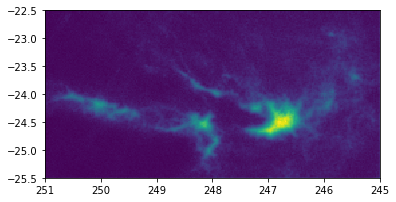

Elapsed time is: 24.16026310622692


In [18]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 250
image = False
scatter = False
contour = False
neighbor = 20

distances = distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

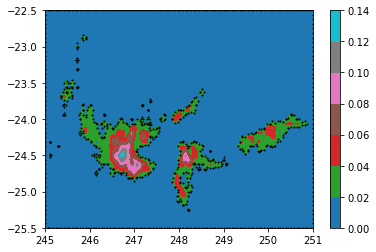

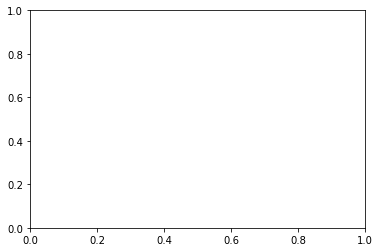

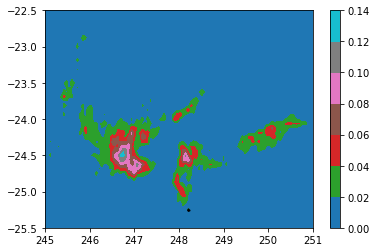

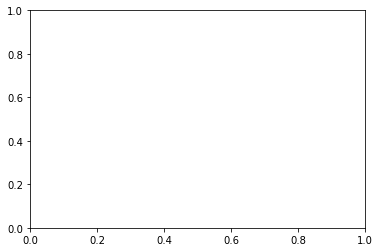

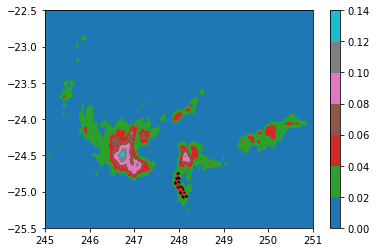

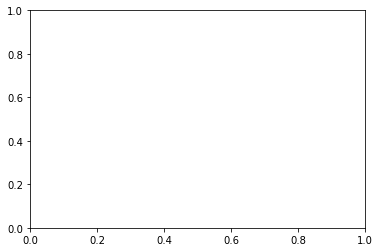

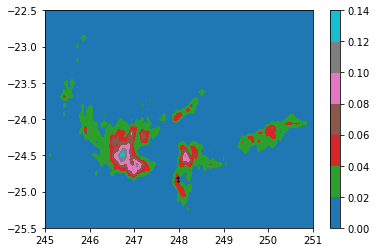

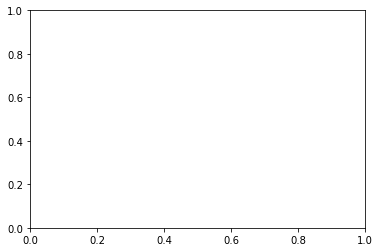

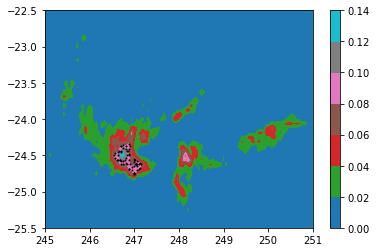

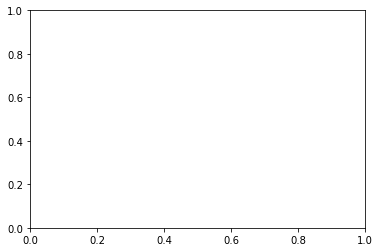

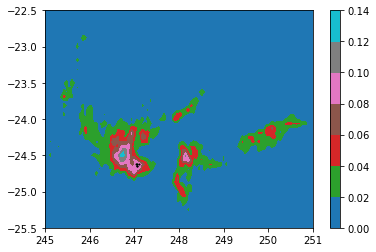

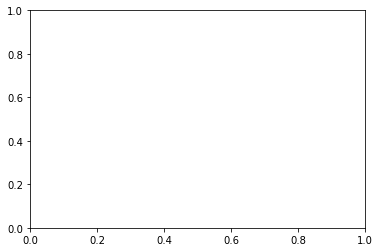

In [67]:
#Find stars between contours

def star_contours(dist,RAmin,RAmax,DEmin,DEmax,L):
    from matplotlib.patches import Circle, Wedge, Polygon
    from matplotlib.collections import PatchCollection
    
    ct = plt.contourf(dist, cmap='tab10',extent=[RAmin,RAmax,DEmin,DEmax])
    plt.xlim(RAmin,RAmax)
    plt.ylim(DEmin,DEmax)
    plt.colorbar()
    
    b = ct.collections[L].get_paths()[0]
    v = b.vertices
    x = v[:,0]
    y = v[:,1]
    plt.scatter(x,y,s=1,c = 'k')
    
    fig, ax = plt.subplots()
    polygon = Polygon(v, True)
    patches = []
    p = PatchCollection(patches, alpha=0.4)
    colors = 100*np.random.rand(len(patches))
    p.set_array((np.array(colors)))
    ax.add_collection(p)
    patches.append(polygon)
    
    plt.show()
    return

A = RAmin
B = RAmax
C = DEmin
D = DEmax

star_contours(distances,A,B,C,D,0)
star_contours(distances,A,B,C,D,1)
star_contours(distances,A,B,C,D,2)
star_contours(distances,A,B,C,D,3)
star_contours(distances,A,B,C,D,4)
star_contours(distances,A,B,C,D,5)

69


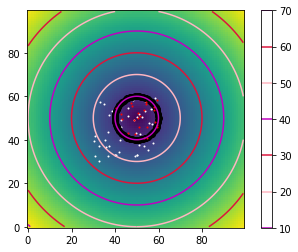

24


In [42]:
#find number of points between contours (test set)

points = np.random.rand(50,2)*30+30
import math
for i in range(0,100):
        for j in range(0,100):
            if (i==0 and j == 0):
                points2 = np.array([0,0])
            else:
                array = [i,j]
                points2 = np.vstack((points2,array))
z= np.zeros((100,100))
for x in range(0,100):
    for y in range(0,100):
        val = math.pow(x-50,2) +math.pow(y-50,2)
        z[x,y] = math.sqrt(val)
plt.imshow(z,origin = 'lower')
plt.scatter(points[:,0],points[:,1],s=1,c='w')
a = plt.contour(z, colors = ['m','lightpink','crimson'])
b = a.collections[0].get_paths()[0]
print(len(b))
plt.colorbar()
v = b.vertices
x = v[:,0]
y = v[:,1]
plt.scatter(x,y,c = 'k')

count = 0
for i in range(len(points)):
    if ((points[i,0] < max(x)) and (points[i,0] > min(x)) and (points[i,1] < max(y)) and (points[i,1] > min(y))):
        plt.scatter(points[i,1],points[i,0],s=1,c = 'r')
        count = count+1
plt.show()
print(count)


In [41]:
#Find number of stars with parallaxes
parallaxes = np.array([])
plx_indices = np.array([])
for i in range(len(plx)):
    if (plx[i] > 0):
        parallaxes = np.append(parallaxes, plx[i])
        plx_indices = np.append(plx_indices, i)
print(len(parallaxes))
distances = 1000/parallaxes

#find index of outlier
for i in range(len(distances)):
    if (distances[i] > 40000):
        print(i)
        print(distances[i])
        
#remove outlier
parallaxes  = np.delete(parallaxes, 61)
plx_indices = np.delete(plx_indices, 61)
distances = np.delete(distances, 61)
print(len(parallaxes))

240
61
50000.0011176
239


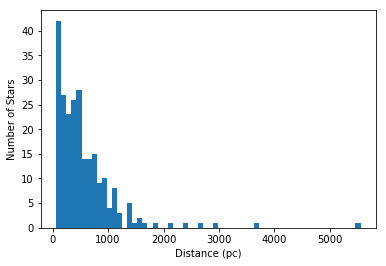

In [39]:
#Create subset of stars of known distances 
RA_dist = np.array([])
DE_dist = np.array([])
for i in plx_indices:
    j = int(i)
    RA_dist = np.append(RA_dist, RA[j])
    DE_dist = np.append(DE_dist, DE[j])
    
plt.hist(distances, bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')
plt.show()

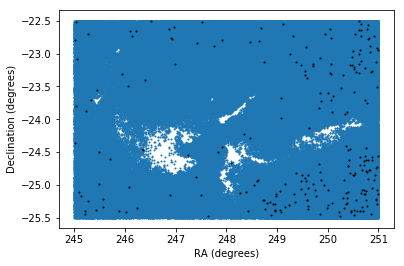

In [38]:
plt.scatter(RA,DE, s = 1)
plt.scatter(RA_dist, DE_dist, s=1, c = 'k')
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

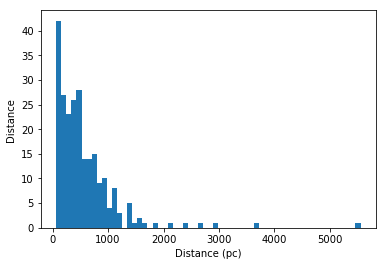

In [40]:
plt.hist(distances, bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Distance ')

In [42]:
count = 0
for i in range(len(distances)):
    if (distances[i] <= 140):
        print(distances[i])
        count = count +1
print(count)

84.817642344
112.233447489
90.4159097703
132.45032778
98.8142303664
135.501352912
126.903551456
80.7102479653
138.31258608
129.366105761
84.745761342
135.317999738
83.963057331
81.1030013129
80.515297412
97.3709791068
103.092785532
87.9507484666
107.296140852
122.399019665
64.3086808832
71.5307605683
90.6618335639
62.3830291432
137.741042489
79.8084613975
97.3709791068
101.832997055
136.425649442
105.042011756
139.275769347
93.4579455912
130.718952619
135.869562753
84.1750833642
84.745761342
36


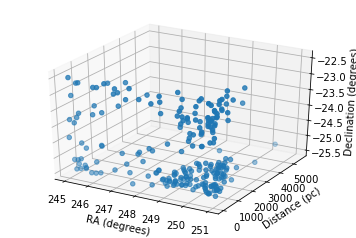

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(RA_dist,distances,DE_dist)
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Distance (pc)')
ax.set_zlabel('Declination (degrees)')

plt.show()

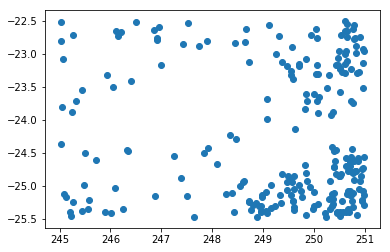

In [45]:
plt.scatter(RA_dist, DE_dist)
plt.show()

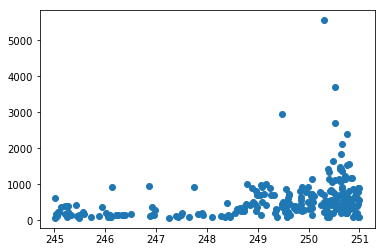

In [46]:
plt.scatter(RA_dist, distances)
plt.show()

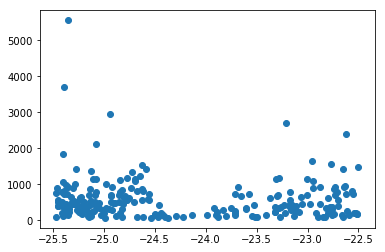

In [47]:
plt.scatter(DE_dist, distances)
plt.show()